In [38]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import typing
import pandas as pd

In [2]:
from soga import *
from lshade import *

In [3]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

Downloading...
From: https://drive.google.com/uc?id=1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
To: /content/fix_targets.pkl
100% 4.21M/4.21M [00:00<00:00, 42.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE
To: /content/fix_sensors.pkl
100% 4.45M/4.45M [00:00<00:00, 43.9MB/s]


In [4]:
with open("/content/fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("/content/fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)

In [5]:
sample = fs_data[0]['small'][10]

In [6]:
class Config(typing.NamedTuple):
    population_size: int
    memory_size: int
    max_evals: int
    bounds: np.array
    seed: int
    activated_penalty: float

In [7]:
bound = [[-0.4, 8.4]]

In [8]:
bound_values = np.repeat(bound, 30, axis=0)

In [ ]:
config = Config(
    population_size=30*18,
    memory_size=10,
    max_evals=1000*30,
    bounds=bound_values,
    seed=29,
    activated_penalty=0.001)

In [ ]:
lshade = LSHADE()
lshade.adapt(sample)

In [ ]:
best, best_val = lshade.solve(config)

In [ ]:
best_val

37.008

# Metrics

In [9]:
def achieved_coverage(x, m, T):
    f = np.zeros((m,), dtype=int)

    for i, val in enumerate(x):
      if val is not None and val != 8:
        for j in range(m):
          if T[i, j, val]:
            f[j] += 1

    return f

In [10]:
def distance_index(k, x):
  k = np.asarray(k)
  x = np.asarray(x)

  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return (a-b)/a


In [11]:
distance_index(sample['K'], achieved_coverage(np.abs(np.rint(best).astype(int)), sample['m'], lshade.T))

NameError: ignored

In [12]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)

  return np.sum(a*a/mk)


In [29]:
def activated_sensors(x, bound):
  x = np.array(x)
  return np.sum(x != bound)

In [14]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

In [15]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    if mask[i] is not None and mask[i] != q:
      S[i, mask[i]] = True

  return np.sum(np.sum(U, axis=2)*S)


In [16]:
import tqdm

In [ ]:
n = 18*30
i = 0
max_iters = 0
while i < config.max_evals:
  max_iters += 1
  n = round((4 - 18*30) / config.max_evals * i + 18*30)
  i += n

In [ ]:
i

30000

In [18]:
index = list(range(0, 118, 3))

In [31]:
DI_fs_soga = []
VAR_fs_soga = []
CQ_fs_soga = []
ACT_fs_soga = []
for i in range(10):
  di = []
  var = []
  cq = []
  act = []
  for id in tqdm.tqdm(index):
    dt = fs_data[i]['small'][id]
    acv_cov, sensors_mask = solve_SOGA(dt)

    DI_score2 = distance_index(np.asarray(dt['K']), acv_cov)
    var_score2 = variance(np.asarray(dt['K']), acv_cov)
    cq_score2 = coverage_quality(sensors_mask, dt)
    act_score = activated_sensors(sensors_mask, None)

    di.append(DI_score2)
    var.append(var_score2)
    cq.append(cq_score2)
    act.append(act_score)

  DI_fs_soga.append(di)
  VAR_fs_soga.append(var)
  CQ_fs_soga.append(cq)
  ACT_fs_soga.append(act)

100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


In [30]:
activated_sensors(sensors_mask, None)

3

In [ ]:
DI_fs_avg_lshade = np.mean(DI_fs_lshade, axis=0)
VAR_fs_avg_lshade = np.mean(VAR_fs_lshade, axis=0)
CQ_fs_avg_lshade = np.mean(CQ_fs_lshade, axis=0)

In [33]:
DI_fs_avg_soga = np.mean(DI_fs_soga, axis=0)
VAR_fs_avg_soga = np.mean(VAR_fs_soga, axis=0)
CQ_fs_avg_soga = np.mean(CQ_fs_soga, axis=0)
ACT_fs_avg_soga = np.mean(ACT_fs_soga, axis=0)

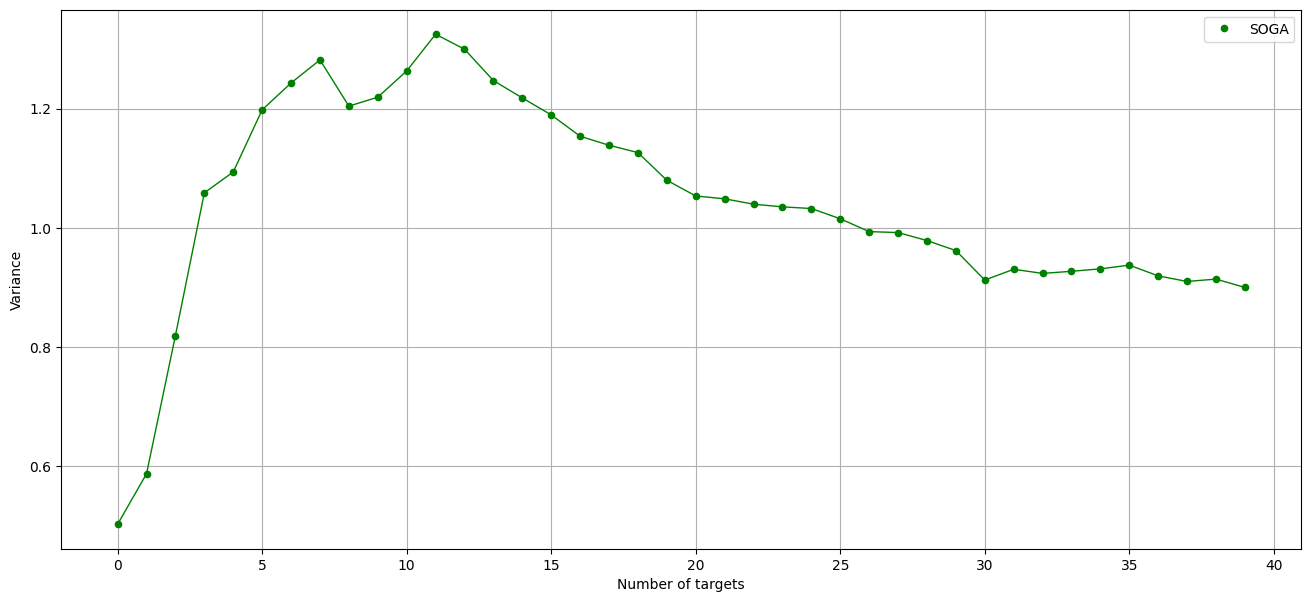

In [34]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(index))
# plt.plot(x_axis, VAR_fs_avg_lshade, 'r-', linewidth=1.0)
# plt.plot(x_axis, VAR_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')

plt.plot(x_axis, VAR_fs_avg_soga, 'g-', linewidth=1.0)
plt.plot(x_axis, VAR_fs_avg_soga, 'go', markersize=4.5, label='SOGA')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.legend()
plt.grid()
plt.show()

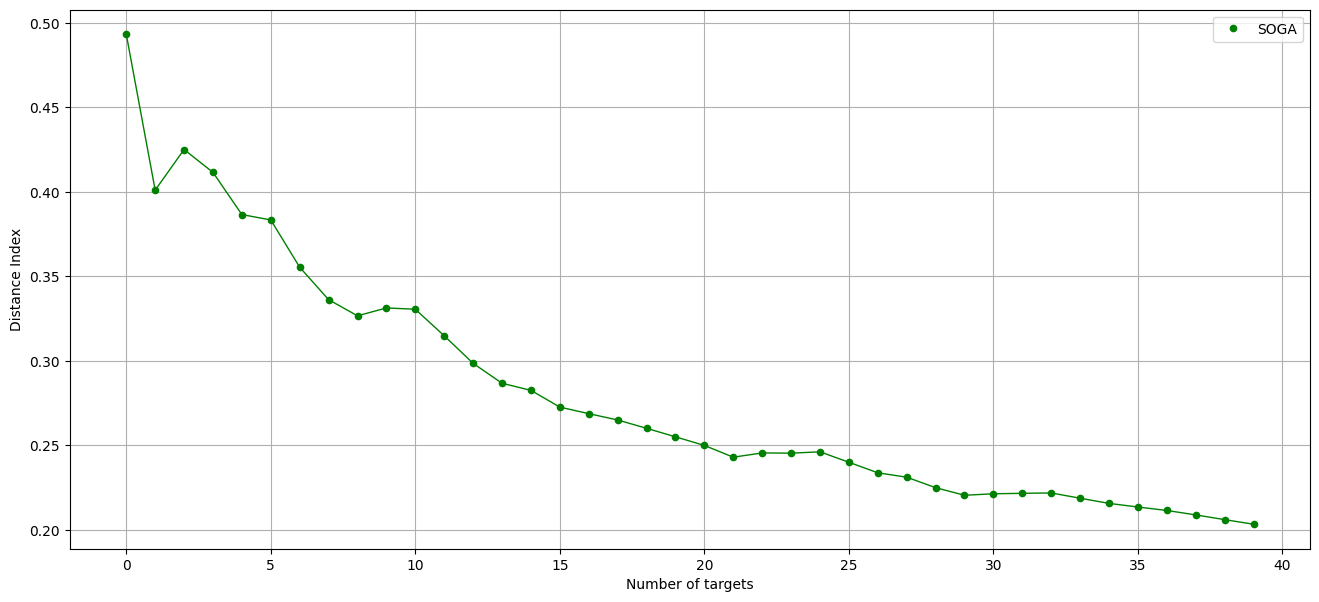

In [35]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(index))
# plt.plot(x_axis, DI_fs_avg_lshade, 'r-', linewidth=1.0)
# plt.plot(x_axis, DI_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')

plt.plot(x_axis, DI_fs_avg_soga, 'g-', linewidth=1.0)
plt.plot(x_axis, DI_fs_avg_soga, 'go', markersize=4.5, label='SOGA')
plt.xlabel("Number of targets")
plt.ylabel("Distance Index")
plt.legend()
plt.grid()
plt.show()

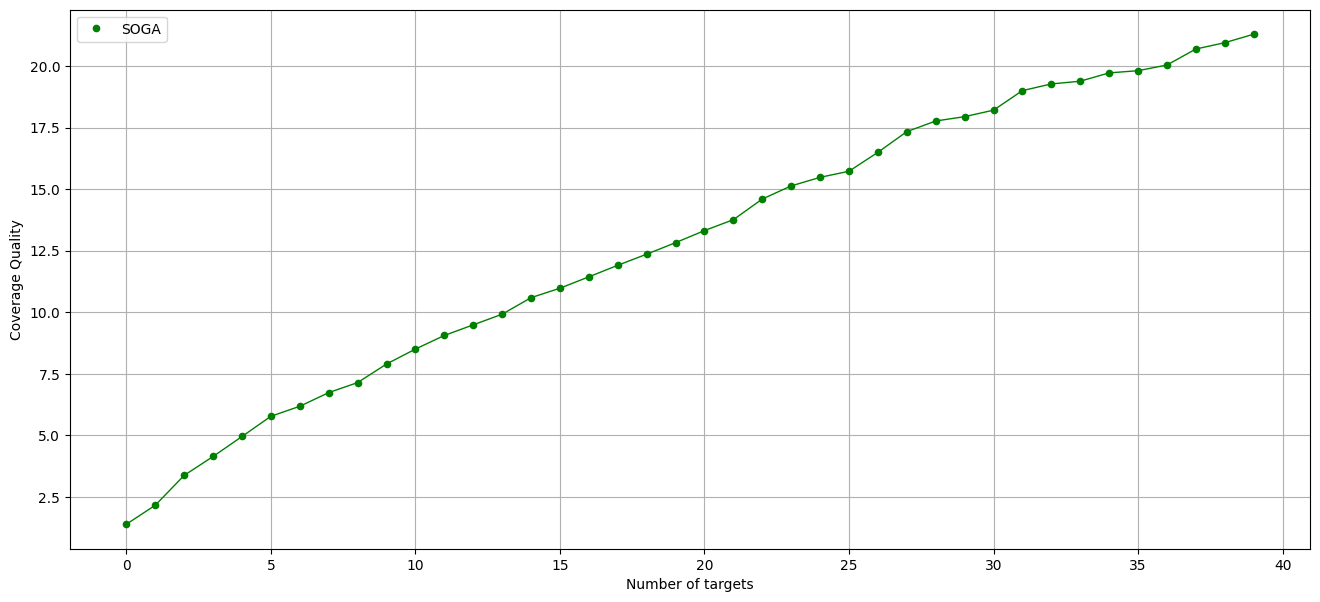

In [36]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(index))
# plt.plot(x_axis, CQ_fs_avg_lshade, 'r-', linewidth=1.0)
# plt.plot(x_axis, CQ_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')

plt.plot(x_axis, CQ_fs_avg_soga, 'g-', linewidth=1.0)
plt.plot(x_axis, CQ_fs_avg_soga, 'go', markersize=4.5, label='SOGA')
plt.xlabel("Number of targets")
plt.ylabel("Coverage Quality")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd

In [ ]:
!gdown 1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF

Downloading...
From: https://drive.google.com/uc?id=1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF
To: /content/Distance_Index_fs.csv
100% 7.12k/7.12k [00:00<00:00, 19.2MB/s]


In [ ]:
!gdown 12FBQPOlkaCwU6uOhXFTVzPQxezssiea0

Downloading...
From: https://drive.google.com/uc?id=12FBQPOlkaCwU6uOhXFTVzPQxezssiea0
To: /content/CQ_fs.csv
100% 6.91k/6.91k [00:00<00:00, 26.5MB/s]


In [ ]:
!gdown 1wWcOtHbITeg5Bzi1Ck5ZhUhFA3xK2h1G

Downloading...
From: https://drive.google.com/uc?id=1wWcOtHbITeg5Bzi1Ck5ZhUhFA3xK2h1G
To: /content/Variance_fs.csv
100% 6.92k/6.92k [00:00<00:00, 24.1MB/s]


In [ ]:
di_fs = pd.read_csv('/content/Distance_Index_fs.csv')

In [ ]:
var_fs = pd.read_csv("/content/Variance_fs.csv")

In [ ]:
cq_fs = pd.read_csv("/content/CQ_fs.csv")

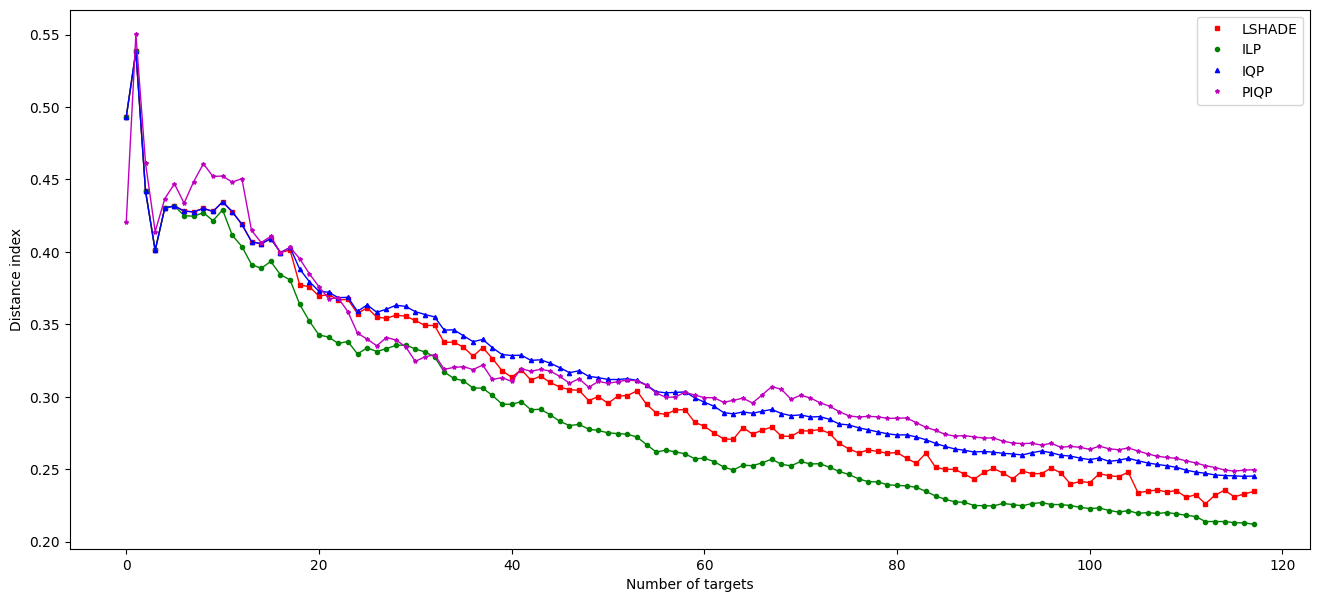

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(DI_fs_avg_lshade))
plt.plot(x_axis, DI_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, DI_fs_avg_lshade, 'rs', markersize=3., label='LSHADE')

plt.plot(x_axis, di_fs['ILP'], 'g-', linewidth=1.0)
plt.plot(x_axis, di_fs['ILP'], 'go', markersize=3., label='ILP')

plt.plot(x_axis, di_fs['IQP'], 'b-', linewidth=1.0)
plt.plot(x_axis, di_fs['IQP'], 'b^', markersize=3., label='IQP')

plt.plot(x_axis, di_fs['PIQP'], 'm-', linewidth=1.0)
plt.plot(x_axis, di_fs['PIQP'], 'm*', markersize=3., label='PIQP')

plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.legend()
plt.show()

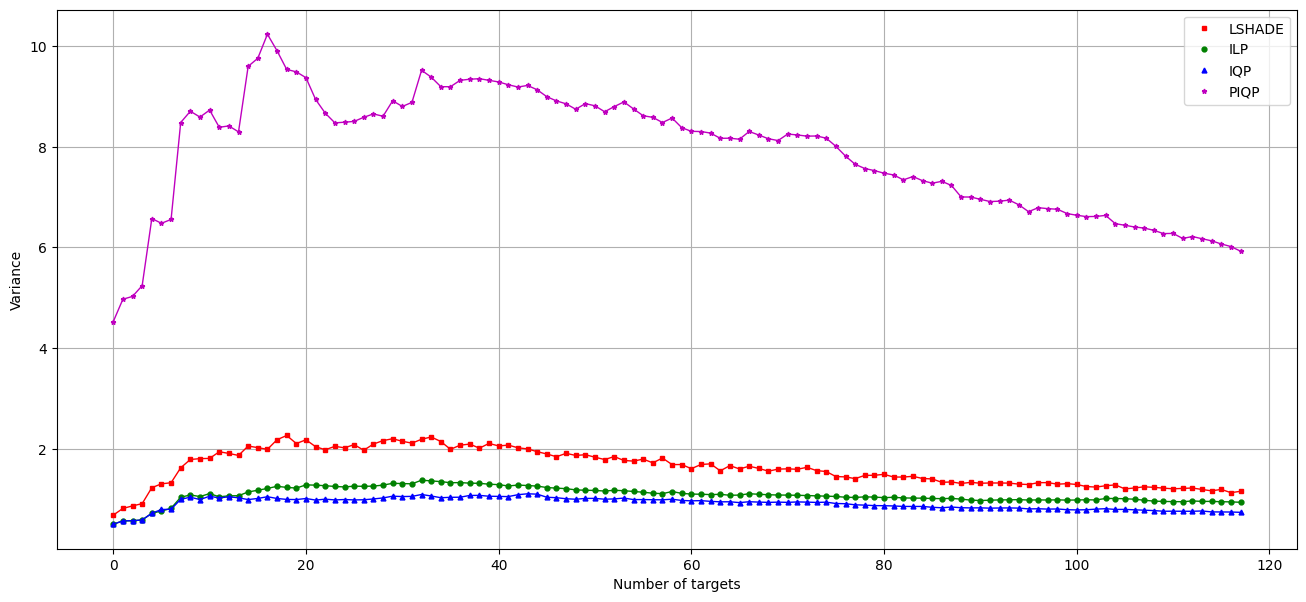

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(VAR_fs_avg_lshade))
plt.plot(x_axis, VAR_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, VAR_fs_avg_lshade, 'rs', markersize=3.5, label='LSHADE')

plt.plot(x_axis, var_fs['ILP'], 'g-', linewidth=1.0)
plt.plot(x_axis, var_fs['ILP'], 'go', markersize=3.5, label='ILP')

plt.plot(x_axis, var_fs['IQP'], 'b-', linewidth=1.0)
plt.plot(x_axis, var_fs['IQP'], 'b^', markersize=3.5, label='IQP')

plt.plot(x_axis, var_fs['PIQP'], 'm-', linewidth=1.0)
plt.plot(x_axis, var_fs['PIQP'], 'm*', markersize=3.5, label='PIQP')

plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.legend()
plt.grid()
plt.show()

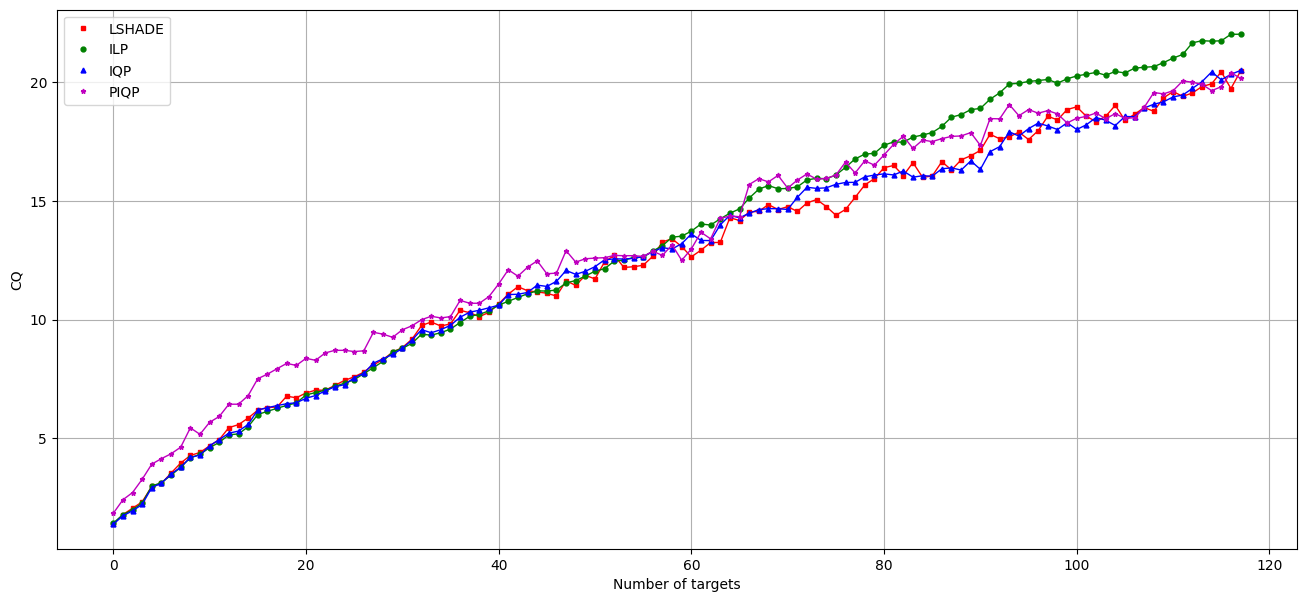

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(CQ_fs_avg_lshade))
plt.plot(x_axis, CQ_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, CQ_fs_avg_lshade, 'rs', markersize=3.5, label='LSHADE')

plt.plot(x_axis, cq_fs['ILP'], 'g-', linewidth=1.0)
plt.plot(x_axis, cq_fs['ILP'], 'go', markersize=3.5, label='ILP')

plt.plot(x_axis, cq_fs['IQP'], 'b-', linewidth=1.0)
plt.plot(x_axis, cq_fs['IQP'], 'b^', markersize=3.5, label='IQP')

plt.plot(x_axis, cq_fs['PIQP'], 'm-', linewidth=1.0)
plt.plot(x_axis, cq_fs['PIQP'], 'm*', markersize=3.5, label='PIQP')

plt.xlabel("Number of targets")
plt.ylabel("CQ")
plt.legend()
plt.grid()
plt.show()

# Fix target

In [32]:
DI_ft_soga = []
CQ_ft_soga = []
ACT_ft_soga = []
for i in range(10):
  di_ft = []
  cq_ft = []
  act_ft = []
  for id in tqdm.tqdm(index):
    dt = ft_data[i]['small'][id]
    acv_cov, sensors_mask = solve_SOGA(dt)

    DI_score = distance_index(np.asarray(dt['K']), acv_cov)
    # var_score = variance(np.asarray(dt['K']), acv_cov)
    cq_score = coverage_quality(sensors_mask, dt)
    act_score = activated_sensors(sensors_mask, None)

    di_ft.append(DI_score)
    cq_ft.append(cq_score)
    act_ft.append(act_score)

  DI_ft_soga.append(di_ft)
  # VAR_fs_soga.append(var)
  CQ_ft_soga.append(cq_ft)
  ACT_ft_soga.append(act_ft)

100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


In [37]:
DI_ft_avg_soga = np.mean(DI_ft_soga, axis=0)
# VAR_ft_avg_soga = np.mean(VAR_ft_soga, axis=0)
CQ_ft_avg_soga = np.mean(CQ_ft_soga, axis=0)
ACT_ft_avg_soga = np.mean(ACT_ft_soga, axis=0)

In [39]:
with open("/content/di_fs_soga.npy", "wb") as f:
  np.save(f, DI_fs_avg_soga)

In [40]:
with open("/content/var_fs_soga.npy", "wb") as f:
  np.save(f, VAR_fs_avg_soga)

In [41]:
with open("/content/cq_fs_soga.npy", "wb") as f:
  np.save(f, CQ_fs_avg_soga)

In [42]:
with open("/content/act_fs_soga.npy", "wb") as f:
  np.save(f, ACT_fs_avg_soga)

In [43]:
with open("/content/di_ft_soga.npy", "wb") as f:
  np.save(f, DI_ft_avg_soga)

In [44]:
with open("/content/cq_ft_soga.npy", "wb") as f:
  np.save(f, CQ_ft_avg_soga)

In [45]:
with open("/content/act_ft_soga.npy", "wb") as f:
  np.save(f, ACT_ft_avg_soga)